In [1]:
%%capture
! pip install xclim

In [2]:
import xesmf
import xarray as xr
import numpy as np
from science_validation_manual import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sbn

In [29]:
input = read_gcs_zarr('gs://scratch-170cd6ec/cfefec08-0dc7-4913-b647-cc6571cb554a/e2e-kace-1-0-g-tasmax-vp8pn-1121105884/timesliced.zarr')

In [34]:
output1 = read_gcs_zarr('gs://scratch-170cd6ec/cfefec08-0dc7-4913-b647-cc6571cb554a/e2e-kace-1-0-g-tasmax-vp8pn-1104684624/standardized.zarr')

In [33]:
output2 = read_gcs_zarr('gs://scratch-170cd6ec/3a2253c8-eaf7-48db-84ca-36f1f78f9117/standardize-cmip6-r6ncl-1503826421/standardized.zarr')

In [30]:
input['tasmax'].isnull().sum().compute()

<xarray.DataArray 'tasmax' ()>
array(0)
Coordinates:
    height   float64 2.0

In [32]:
output1['tasmax'].isnull().sum().compute()

<xarray.DataArray 'tasmax' ()>
array(27648)

In [35]:
output2['tasmax'].isnull().sum().compute()

<xarray.DataArray 'tasmax' ()>
array(0)

In [3]:
import rhg_compute_tools.kubernetes as rhgk

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [4]:
client, cluster = rhgk.get_micro_cluster()

In [5]:
cluster.scale(100)

In [6]:
cluster

In [151]:
# client.restart()
# client.close()
# cluster.close()

# Output data

In [34]:
# from workflow : https://argo.cildc6.org/workflows/default/biascorrectdownscale-precipitation-dev-lkbcg?tab=workflow&nodeId=biascorrectdownscale-precipitation-dev-lkbcg-1820029764&nodePanelView=inputs-outputs

gcm = 'GFDL-ESM4'
ssp = 'ssp370'

datadict = {
    'reference-clean': 'gs://clean-b1dbca25/reanalysis/ERA-5/F320/pr.1995-2015.F320.zarr',
    'reference-qdm': 'gs://support-c23ff1a3/qdm-reference/pr/v20220201000555.zarr',
    'reference-qplad-fine': 'gs://support-c23ff1a3/qplad-fine-reference/pr/v20220201000555.zarr',
    'reference-qplad-coarse': 'gs://support-c23ff1a3/qplad-coarse-reference/pr/v20220201000555.zarr',
    'gcm-clean-future': 'gs://clean-b1dbca25/cmip6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp370/r1i1p1f1/day/pr/gr1/v20180701.zarr',
    'gcm-clean-historical': 'gs://clean-b1dbca25/cmip6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/day/pr/gr1/v20190726.zarr',
    'gcm-biascorrected-future':'gs://biascorrected-492e989a/stage/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp370/r1i1p1f1/day/pr/gr1/v20220211070751.zarr',
    'gcm-downscaled-future': 'gs://downscaled-288ec5ac/stage/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp370/r1i1p1f1/day/pr/gr1/v20220211070751.zarr',
}

In [35]:
for key, val in datadict.items():
    datadict[key] = read_gcs_zarr(val)['pr']

## 1. bidecadal maps of 
### - the mean among values > 1 across time
### - the max value across time
#### Note : for the mean, color bar ranges from 0-20 (mm), and for the max, 0-100.

In [36]:
def series_two_decades(start, end, datadict):
    
    reference_clean_mean = datadict['reference-clean'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).where(datadict['reference-clean']>1).mean('time').compute()
    gcm_clean_historical_mean = datadict['gcm-clean-historical'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).where(datadict['gcm-clean-historical']>1).mean('time').compute()
    gcm_clean_future_mean = datadict['gcm-clean-future'].sel(time=slice(start, end)).where(datadict['gcm-clean-future']>1).mean('time').compute()
    gcm_biascorrected_future_mean = datadict['gcm-biascorrected-future'].sel(time=slice(start, end)).where(datadict['gcm-biascorrected-future']>1).mean('time').compute()
    gcm_downscaled_future_mean = datadict['gcm-downscaled-future'].sel(time=slice(start, end)).where(datadict['gcm-downscaled-future']>1).mean('time').compute()
    
    plotdict = {
        'reference_mean': reference_clean_mean,
        'gcm_training_mean': gcm_clean_historical_mean,
        'gcm_future_mean': gcm_clean_future_mean,
        'gcm_biascorrected_future_mean': gcm_biascorrected_future_mean,
        'gcm_downscaled_future_mean': gcm_downscaled_future_mean
    }
    
    simple_plot_series(da_dict=plotdict, vmin=0, vmax=20, size=[40, 40])
    
    reference_clean_max = datadict['reference-clean'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).where(datadict['reference-clean']>1).max('time').compute()
    gcm_clean_historical_max = datadict['gcm-clean-historical'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).where(datadict['gcm-clean-historical']>1).max('time').compute()
    gcm_clean_future_max = datadict['gcm-clean-future'].sel(time=slice(start, end)).where(datadict['gcm-clean-future']>1).max('time').compute()
    gcm_biascorrected_future_max = datadict['gcm-biascorrected-future'].sel(time=slice(start, end)).where(datadict['gcm-biascorrected-future']>1).max('time').compute()
    gcm_downscaled_future_max = datadict['gcm-downscaled-future'].sel(time=slice(start, end)).where(datadict['gcm-downscaled-future']>1).max('time').compute()
    
    plotdict = {
        'reference_max': reference_clean_max,
        'gcm_training_max': gcm_clean_historical_max,
        'gcm_future_max': gcm_clean_future_max,
        'gcm_biascorrected_future_max': gcm_biascorrected_future_max,
        'gcm_downscaled_future_max': gcm_downscaled_future_max
    }
    
    simple_plot_series(da_dict=plotdict, vmin=0, vmax=100, size=[40, 40])

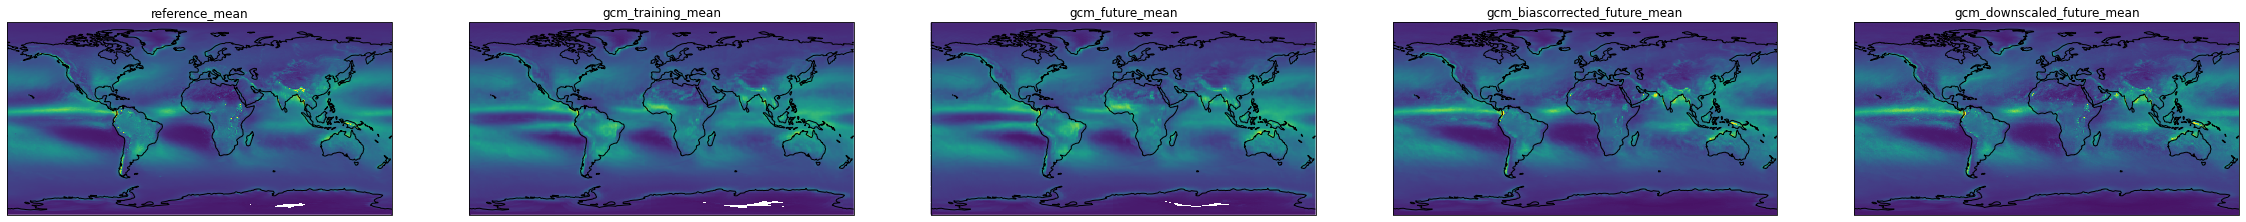

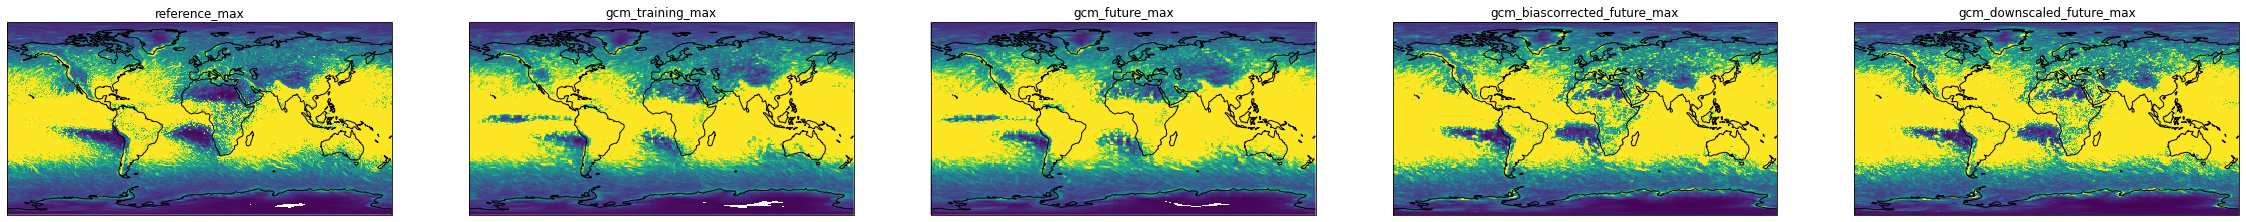

In [37]:
series_two_decades(start='2020', end='2040', datadict=datadict)

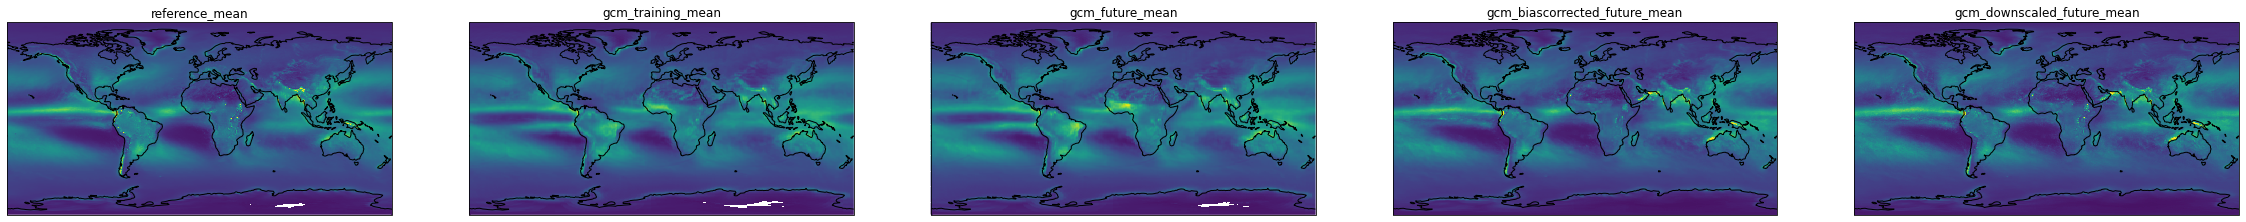

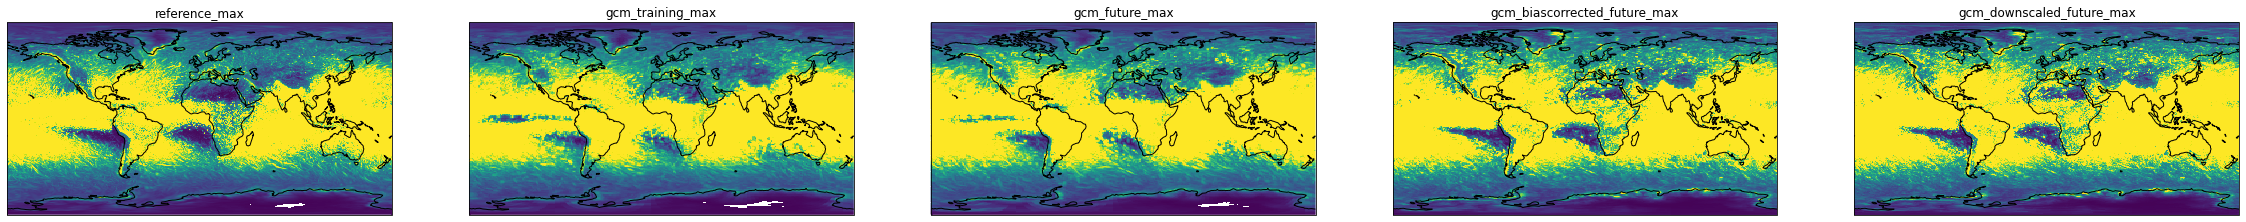

In [38]:
series_two_decades(start='2040', end='2060', datadict=datadict)

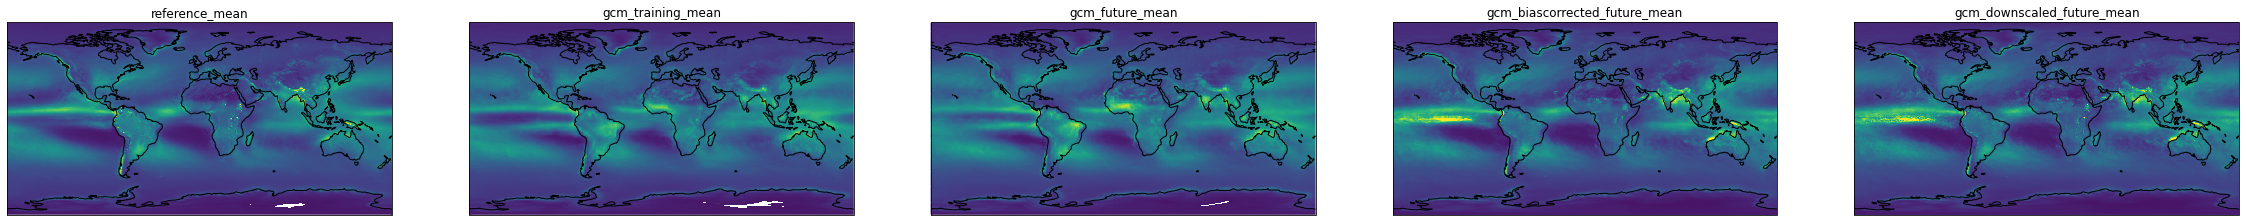

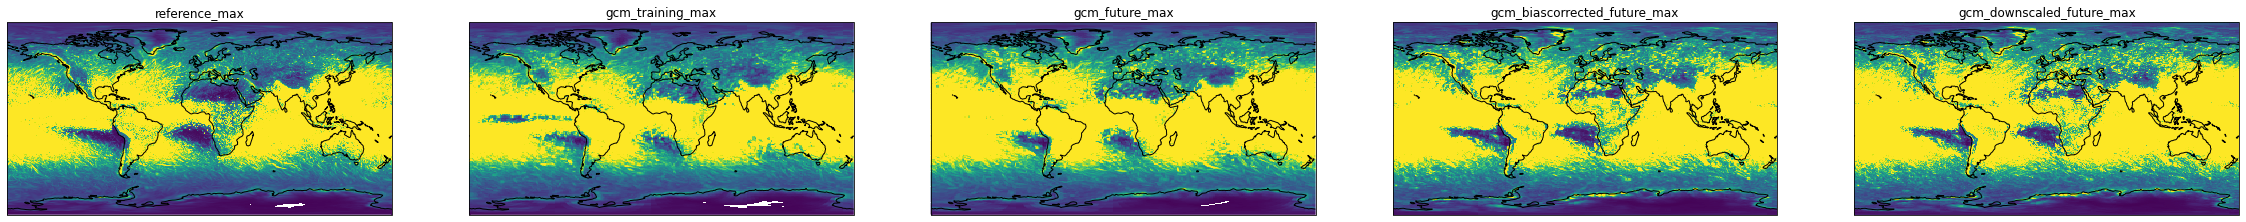

In [39]:
series_two_decades(start='2060', end='2080', datadict=datadict)

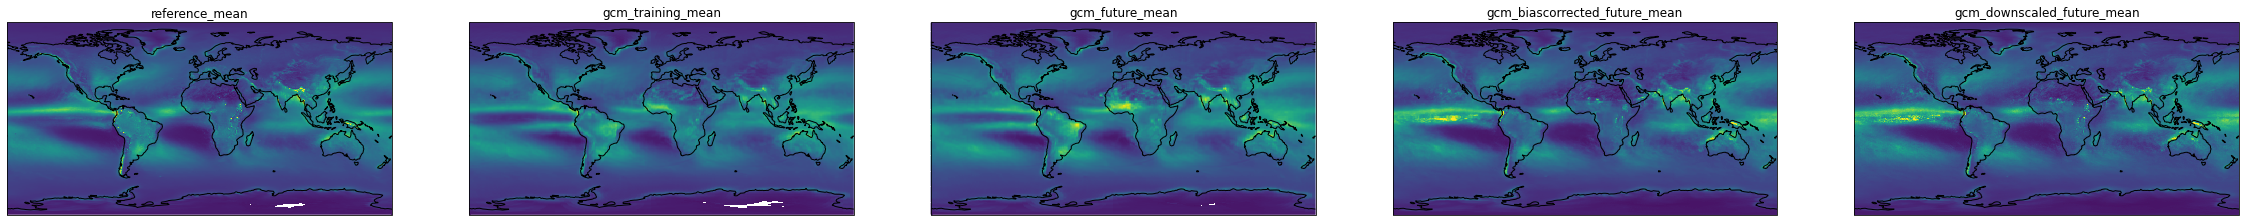

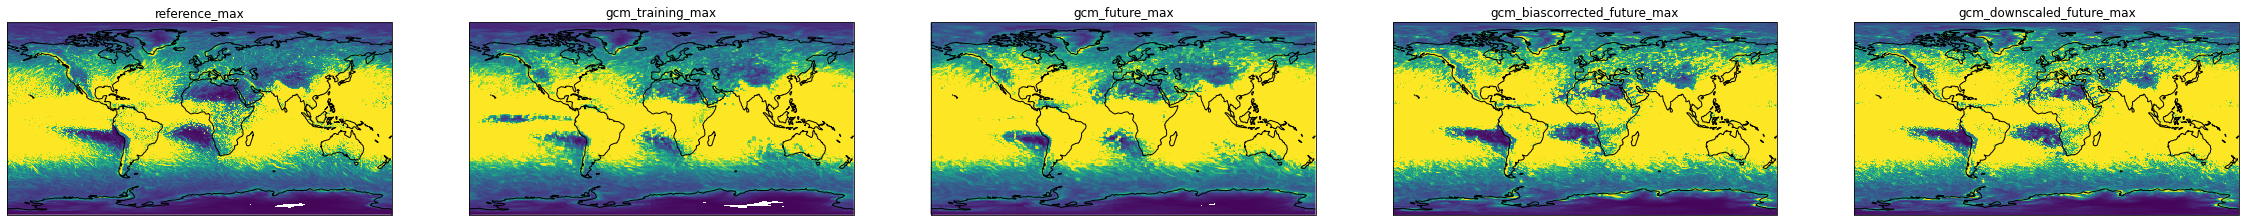

In [40]:
series_two_decades(start='2080', end='2100', datadict=datadict)

## 2. Deeper dive into a few cells distribution across time (again, bidecadal)

##### Seoul 36.72 127.18
##### Paris 49.18 2.14
##### Kolkata 22.56 88.36
##### Niamey 13.69 2.31 
##### Gujarat 22.7 69.32
(The latter in particular sheds light on what the averages maps show)

### Three empirical distribution function plots (distribution across time for a given cell) with a curve for each dataset :
#### - for the QDM method check : 
    - reference, training, gcm-future-clean, gcm-future-biascorrected, gcm-future-downscaled
    - same as the above zooming in highest quantiles
#### - for the QPLAD method check : 
    - reference-fine, reference-coarse, biascorrected, downscaled (zooming in highest quantiles)

In [41]:
def series_cities_two_decades(city, start, end, datadict, zoom_in=(0.95, 1.0)):
   
    citydict = {
        'Seoul':[36.72, 127.18],
        'Paris':[49.18, 2.14],
        'Niamey':[13.69, 2.31],
        'Kolkata':[22.56, 88.36],
        'Gujarat':[22.7, 69.32]
    }
    
    lat, lon = citydict[city][0],citydict[city][1]
    
    reference_clean = datadict['reference-clean'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).sel(lat=lat, lon=lon, method='nearest').compute()
    gcm_clean_historical = datadict['gcm-clean-historical'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).sel(lat=lat, lon=lon, method='nearest').compute()
    gcm_clean_future = datadict['gcm-clean-future'].sel(time=slice(start, end)).sel(lat=lat, lon=lon, method='nearest').compute()
    gcm_biascorrected_future = datadict['gcm-biascorrected-future'].sel(time=slice(start, end)).sel(lat=lat, lon=lon, method='nearest').compute()
    gcm_downscaled_future = datadict['gcm-downscaled-future'].sel(time=slice(start, end)).sel(lat=lat, lon=lon, method='nearest').compute()
    reference_qplad_fine = datadict['reference-qplad-fine'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).sel(lat=lat, lon=lon, method='nearest').compute()
    reference_qplad_coarse = datadict['reference-qplad-coarse'].sel({'time': slice('1994-12-17', '2015-01-15', None)}).sel(lat=lat, lon=lon, method='nearest').compute()
    
    plt.figure(figsize=(14, 4))
    sbn.ecdfplot(reference_clean, label='reference')
    sbn.ecdfplot(gcm_clean_historical, label='gcm training')
    sbn.ecdfplot(gcm_clean_future, label='gcm future')
    sbn.ecdfplot(gcm_biascorrected_future, label='gcm future biascorrected')
    sbn.ecdfplot(gcm_downscaled_future,label='gcm future downscaled')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.ylabel('quantile')
    plt.xlabel('precip (mm)')
    plt.title(f'{city} precip ECDF, all quantiles')
    
    plt.figure(figsize=(14, 4))
    sbn.ecdfplot(reference_clean, label='reference')
    sbn.ecdfplot(gcm_clean_historical, label='gcm training')
    sbn.ecdfplot(gcm_clean_future, label='gcm future')
    sbn.ecdfplot(gcm_biascorrected_future, label='gcm future biascorrected')
    sbn.ecdfplot(gcm_downscaled_future,label='gcm future downscaled')
    plt.ylim(zoom_in[0], zoom_in[1])
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.ylabel('quantile')
    plt.xlabel('precip (mm)')
    plt.title(f'{city} precip ECDF, zooming in highest quantiles')
    

    plt.figure(figsize=(14, 4))
    sbn.ecdfplot(reference_qplad_fine, label='reference-qplad-fine')
    sbn.ecdfplot(reference_qplad_coarse, label='reference-qplad-coarse')
    sbn.ecdfplot(gcm_biascorrected_future, label='gcm future biascorrected')
    sbn.ecdfplot(gcm_downscaled_future,label='gcm future downscaled')
    plt.ylim(zoom_in[0], zoom_in[1])
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.ylabel('quantile')
    plt.xlabel('precip (mm)')
    plt.title(f'{city} precip ECDF, zooming in highest quantiles')

## Seoul

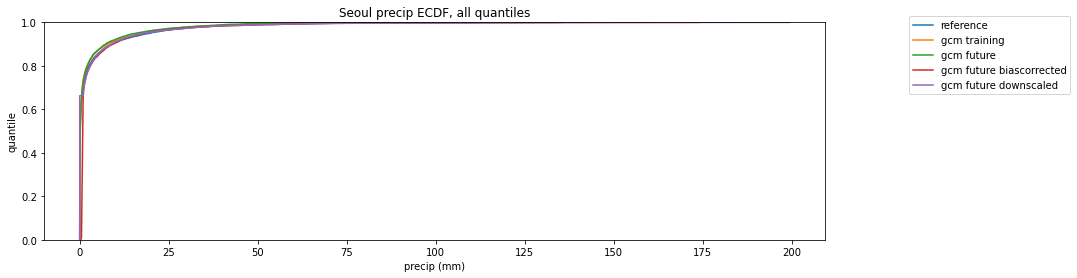

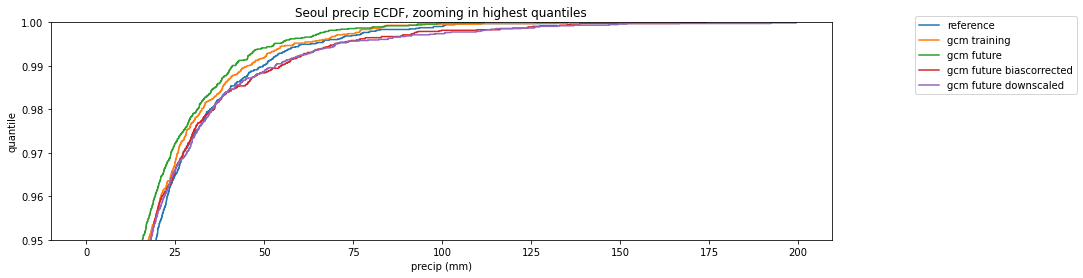

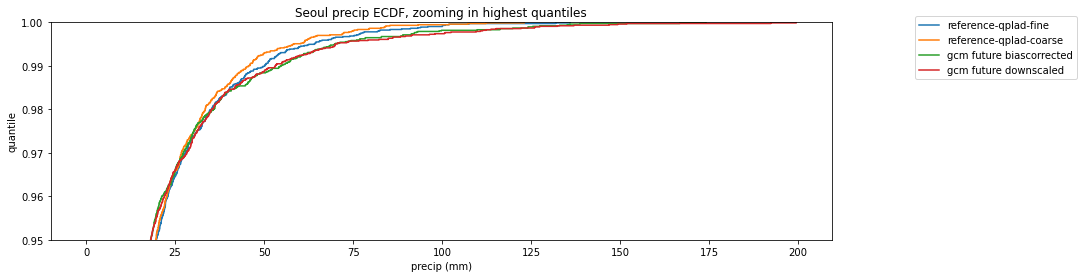

In [42]:
%%capture --no-display
series_cities_two_decades(city='Seoul', start='2020', end='2040', datadict=datadict)

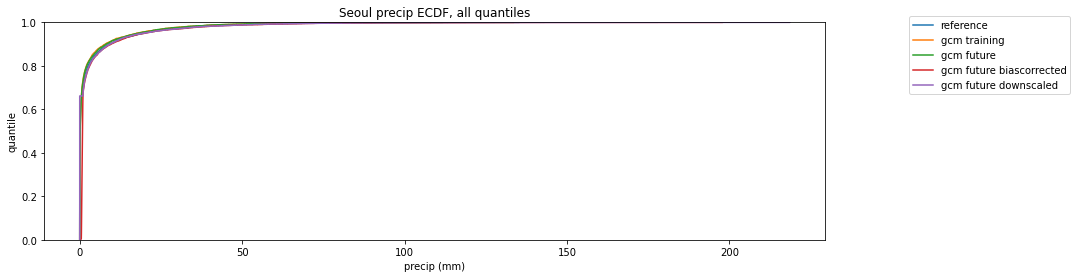

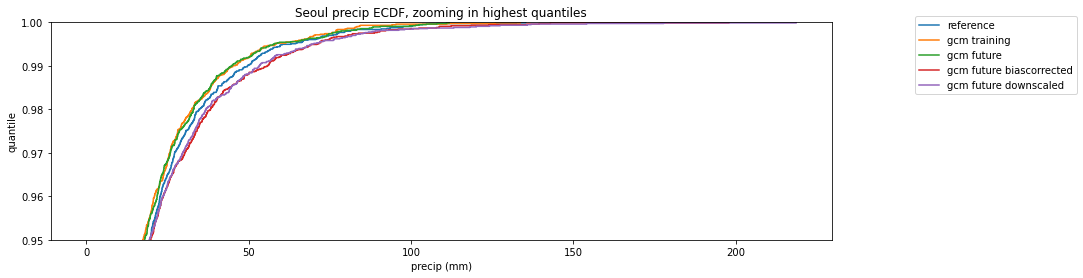

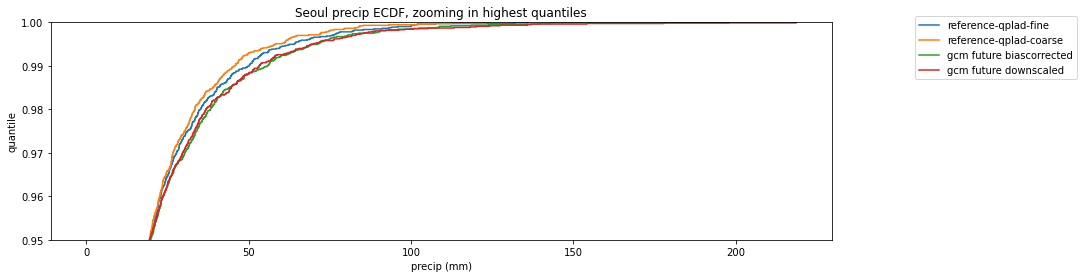

In [43]:
%%capture --no-display
series_cities_two_decades(city='Seoul', start='2040', end='2060', datadict=datadict)

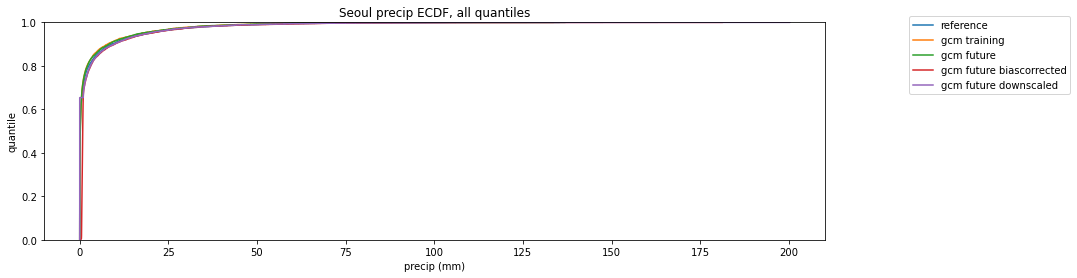

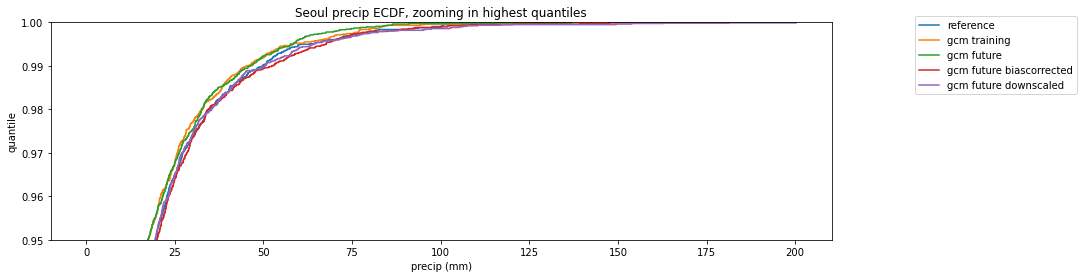

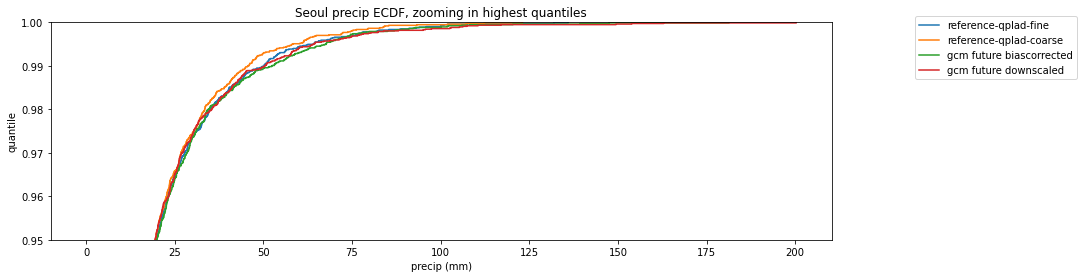

In [44]:
%%capture --no-display
series_cities_two_decades(city='Seoul', start='2060', end='2080', datadict=datadict)

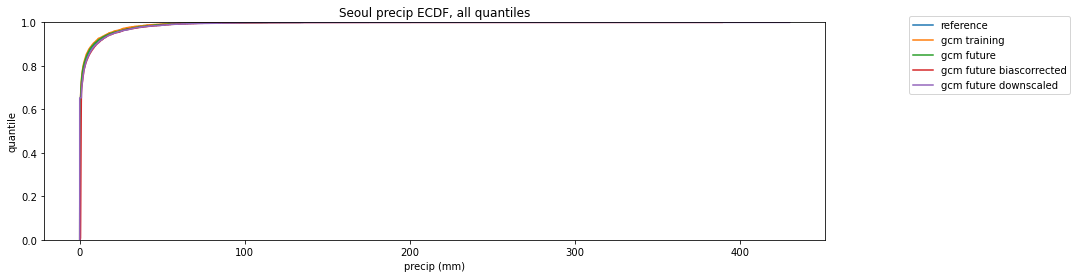

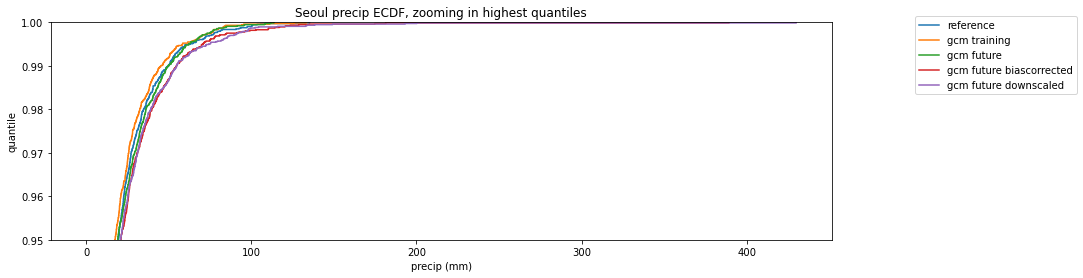

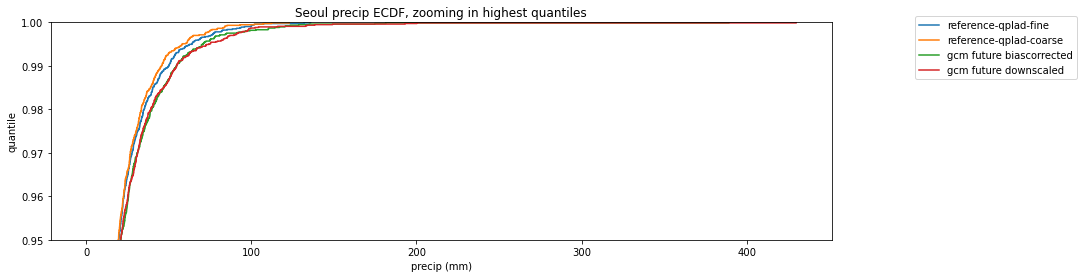

In [45]:
%%capture --no-display
series_cities_two_decades(city='Seoul', start='2080', end='2100', datadict=datadict)

## Paris

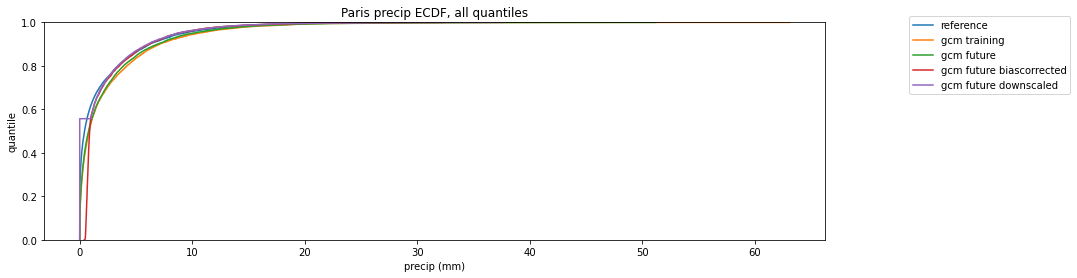

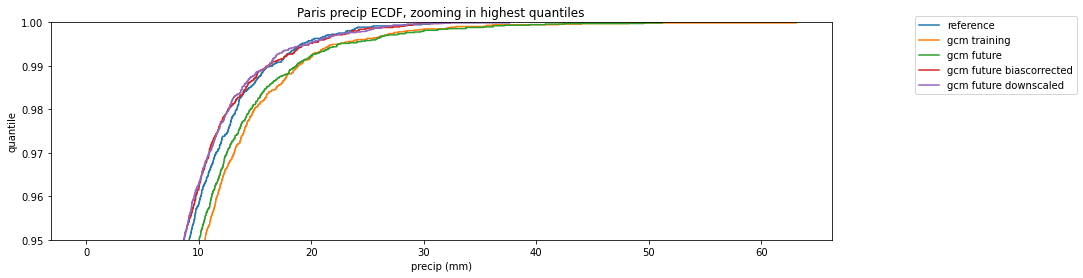

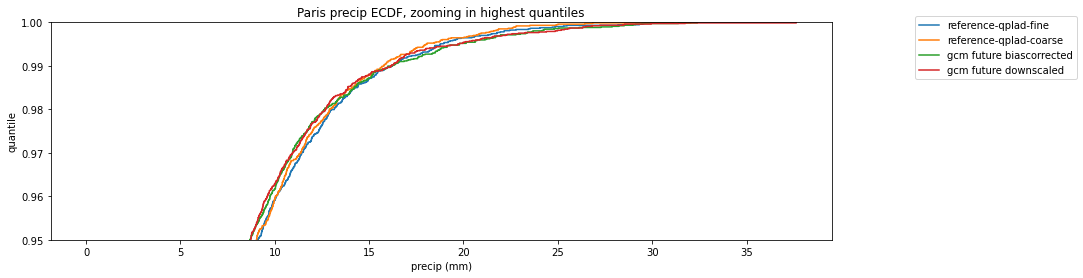

In [46]:
%%capture --no-display
series_cities_two_decades(city='Paris', start='2020', end='2040', datadict=datadict)

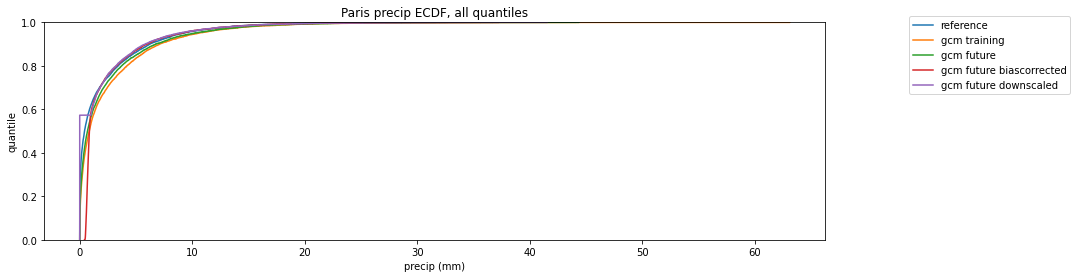

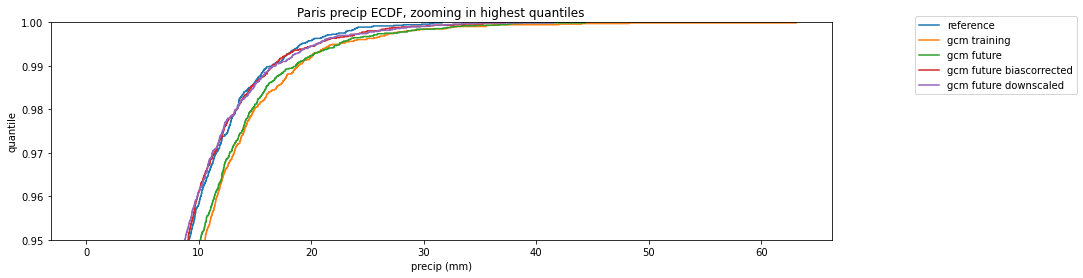

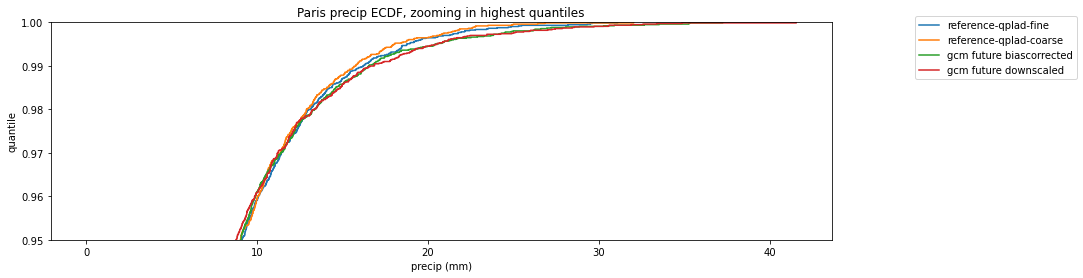

In [47]:
%%capture --no-display
series_cities_two_decades(city='Paris', start='2040', end='2060', datadict=datadict)

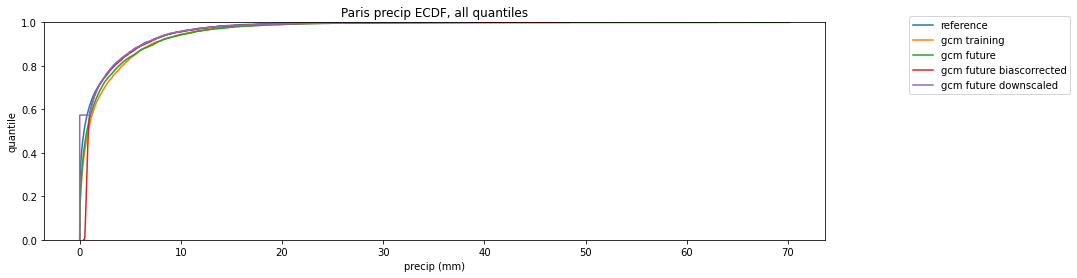

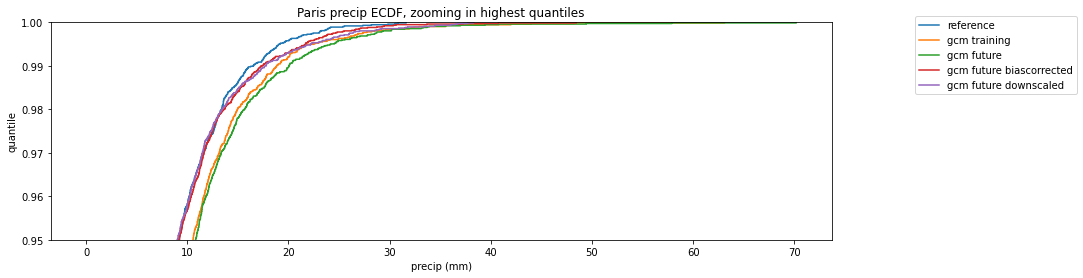

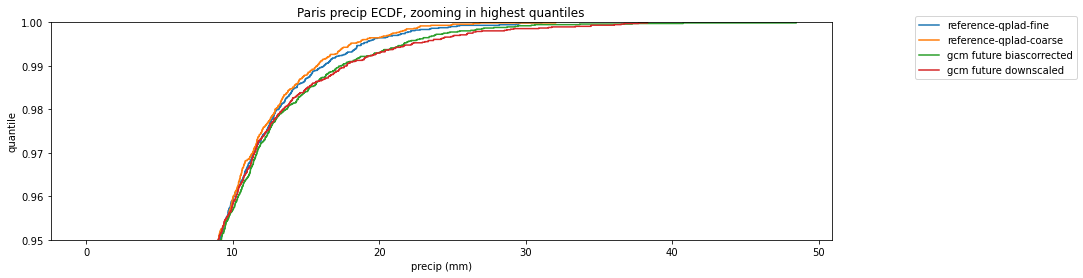

In [48]:
%%capture --no-display
series_cities_two_decades(city='Paris', start='2060', end='2080', datadict=datadict)

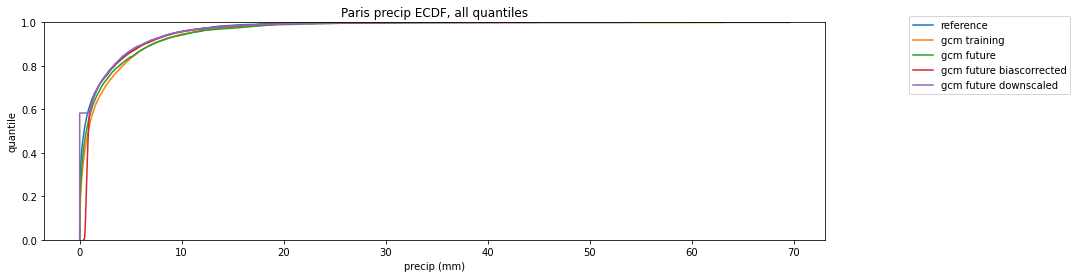

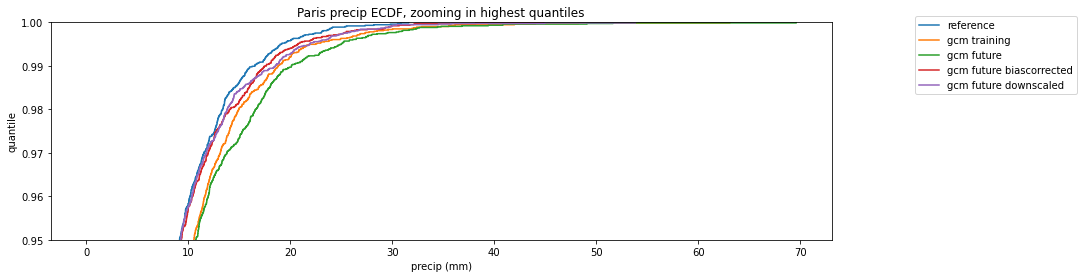

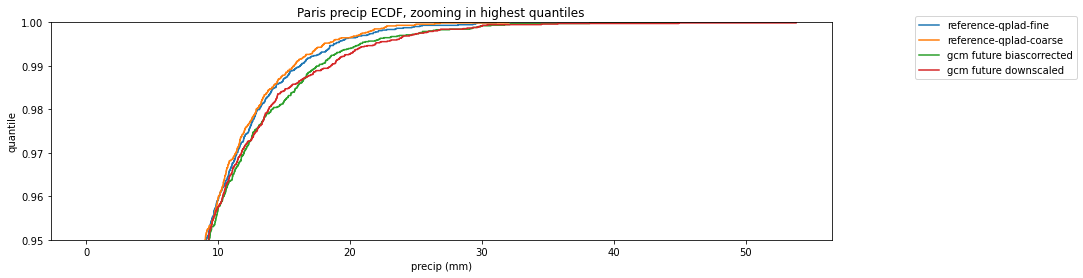

In [49]:
%%capture --no-display
series_cities_two_decades(city='Paris', start='2080', end='2100', datadict=datadict)

## Niamey

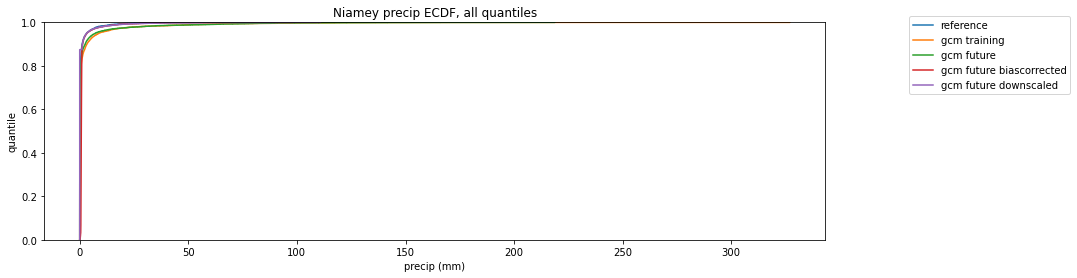

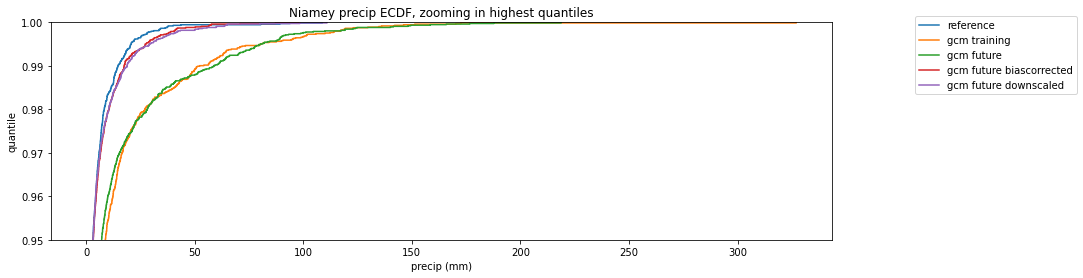

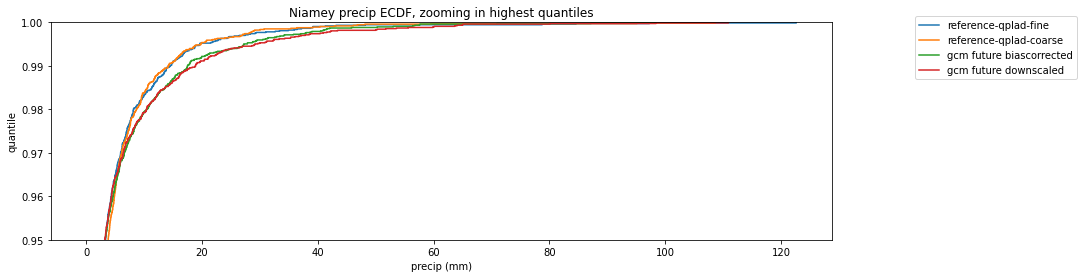

In [50]:
%%capture --no-display
series_cities_two_decades(city='Niamey', start='2020', end='2040', datadict=datadict)

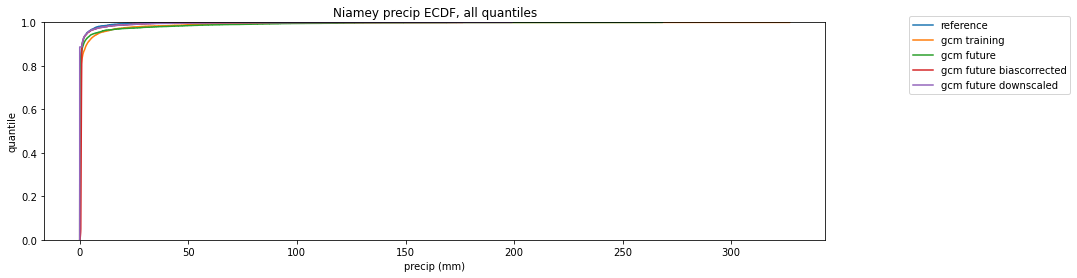

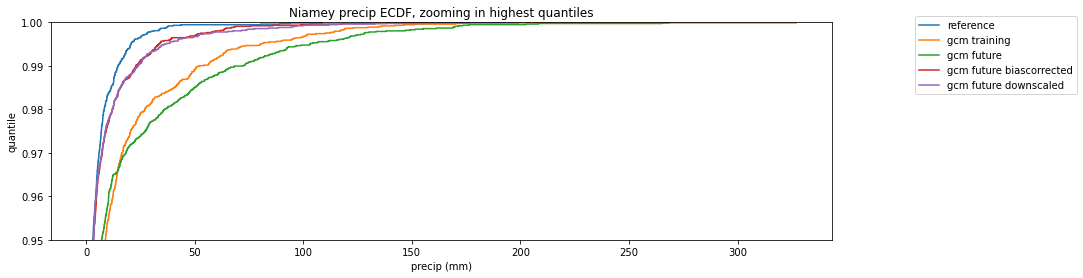

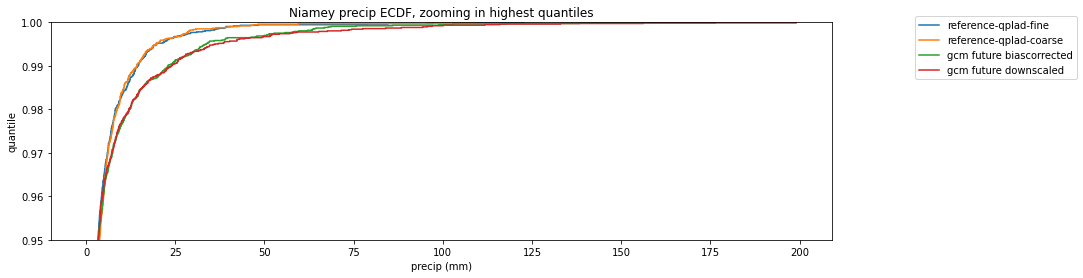

In [51]:
%%capture --no-display
series_cities_two_decades(city='Niamey', start='2040', end='2060', datadict=datadict)

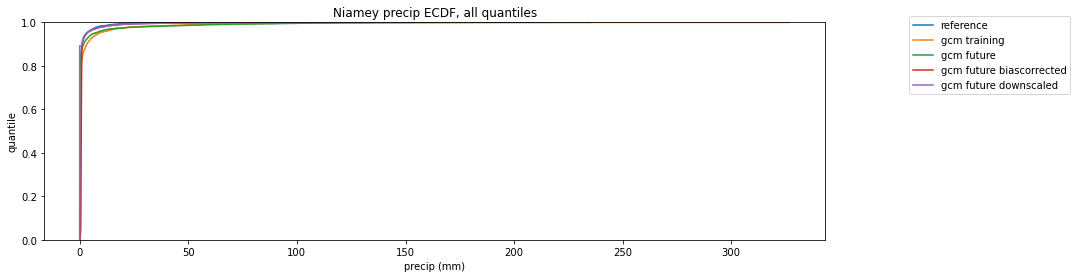

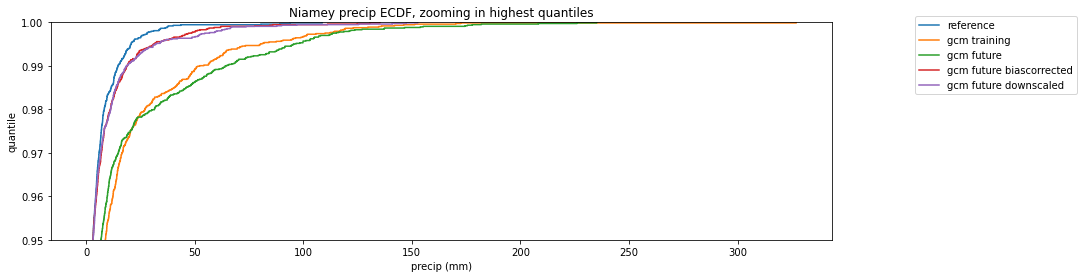

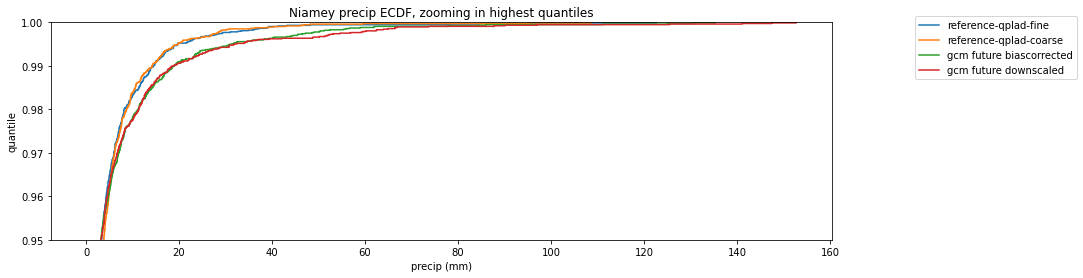

In [52]:
%%capture --no-display
series_cities_two_decades(city='Niamey', start='2060', end='2080', datadict=datadict)

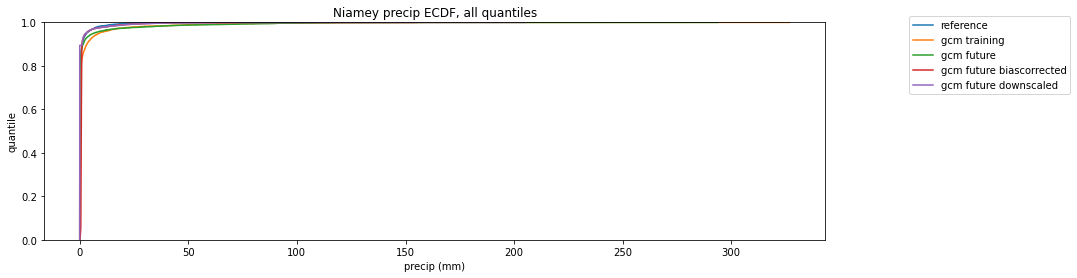

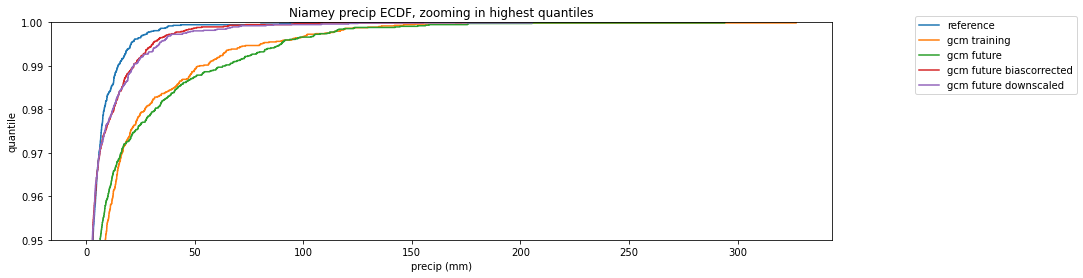

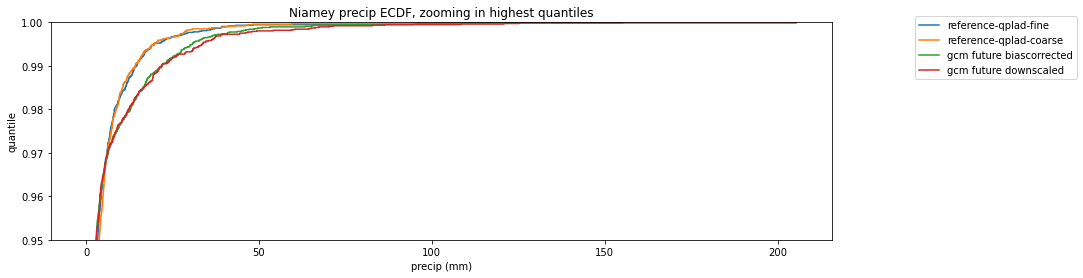

In [53]:
%%capture --no-display
series_cities_two_decades(city='Niamey', start='2080', end='2100', datadict=datadict)

## Kolkata

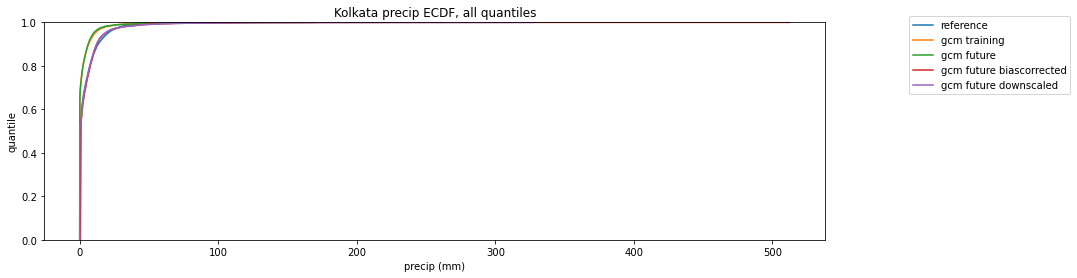

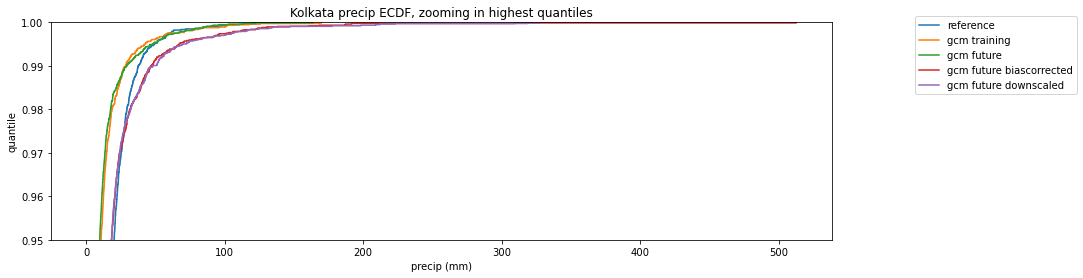

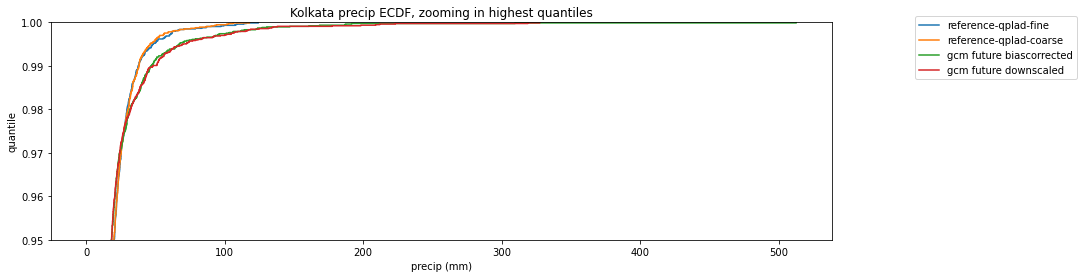

In [54]:
%%capture --no-display
series_cities_two_decades(city='Kolkata', start='2020', end='2040', datadict=datadict)

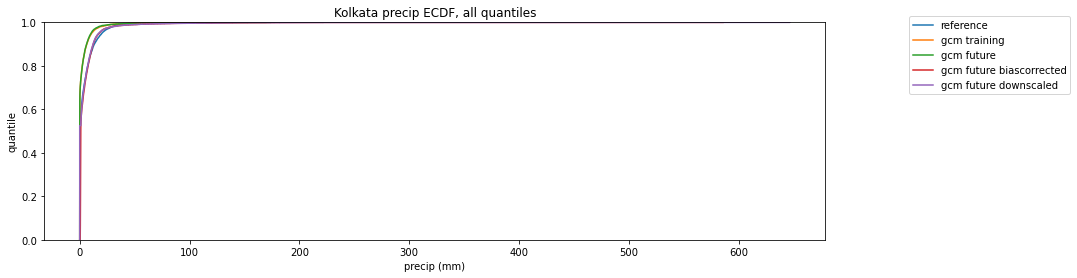

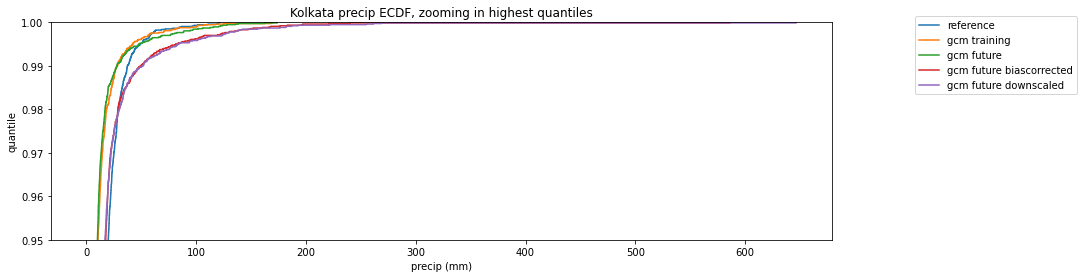

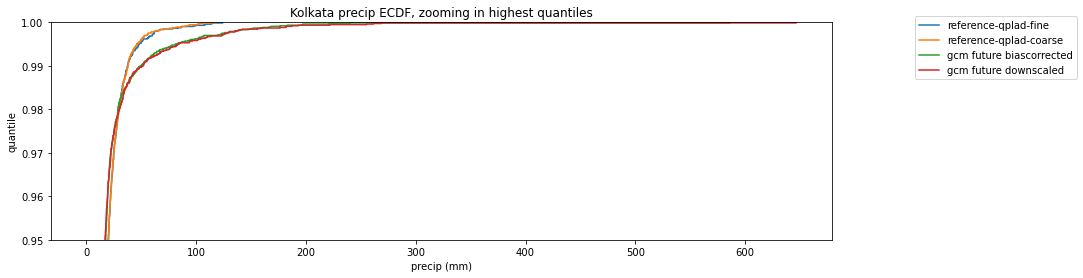

In [55]:
%%capture --no-display
series_cities_two_decades(city='Kolkata', start='2040', end='2060', datadict=datadict)

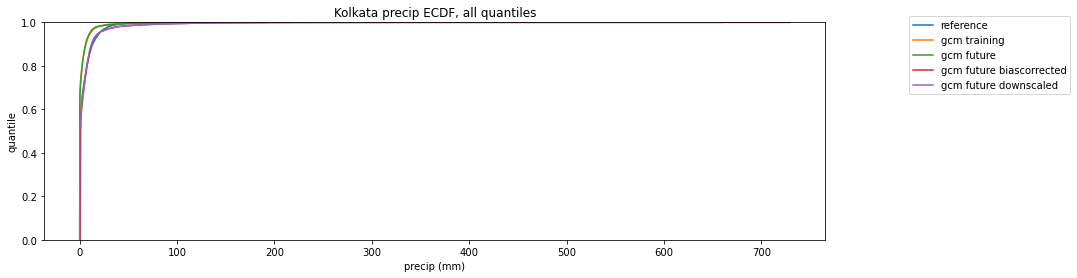

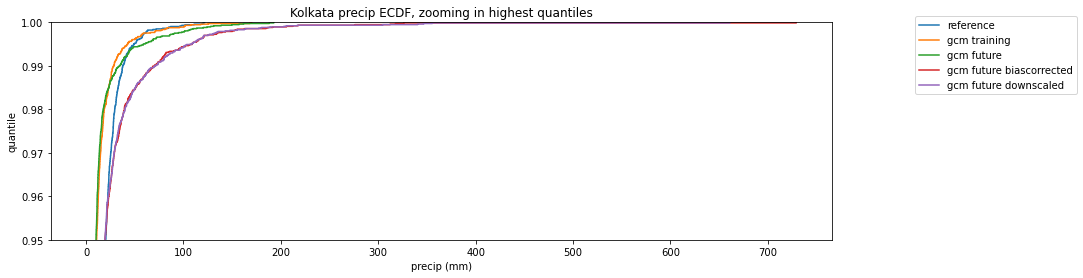

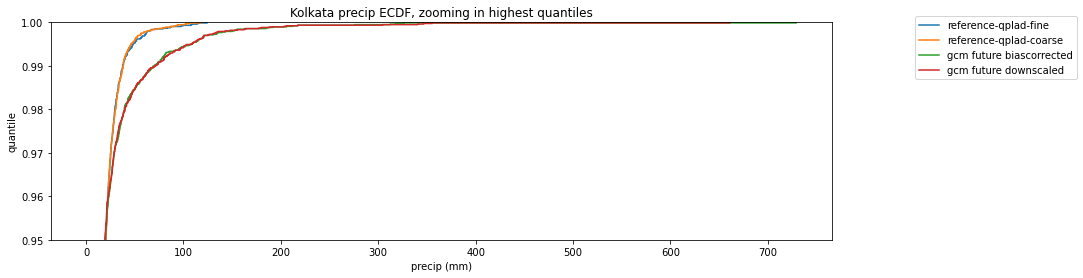

In [56]:
%%capture --no-display
series_cities_two_decades(city='Kolkata', start='2060', end='2080', datadict=datadict)

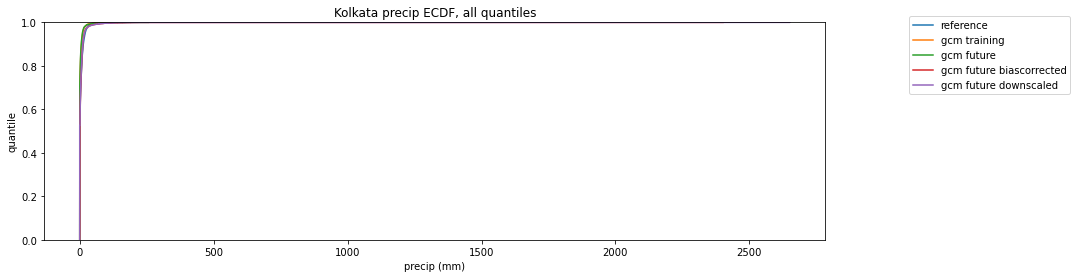

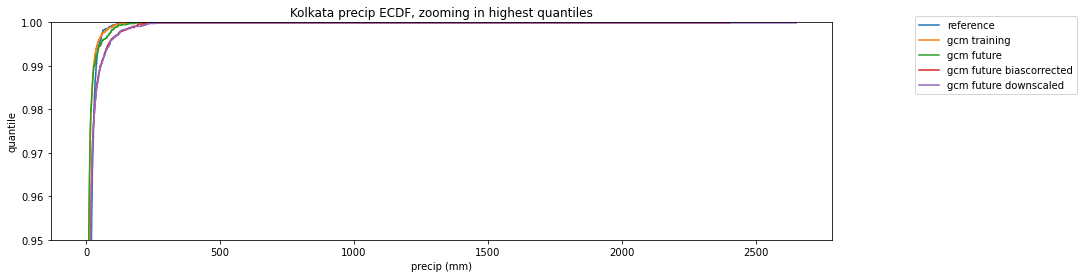

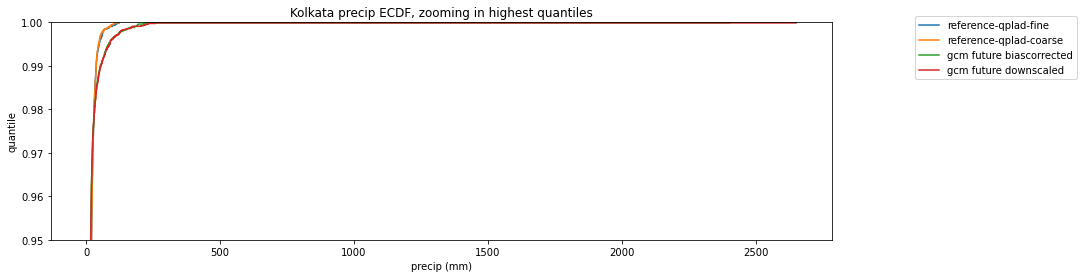

In [57]:
%%capture --no-display
series_cities_two_decades(city='Kolkata', start='2080', end='2100', datadict=datadict)

## Gujarat

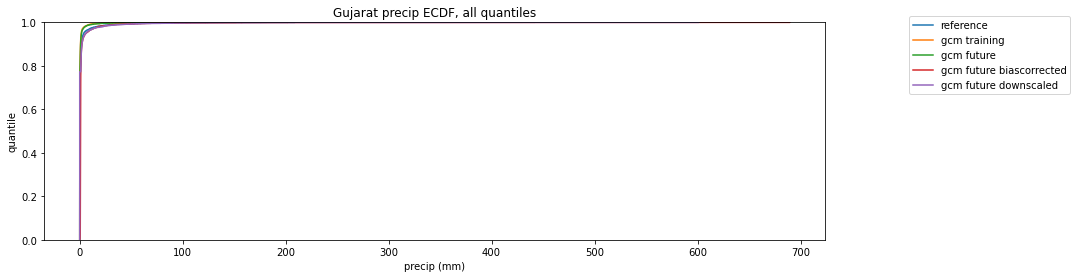

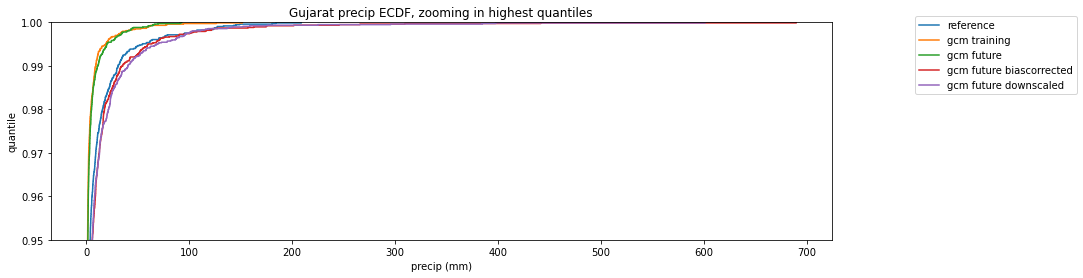

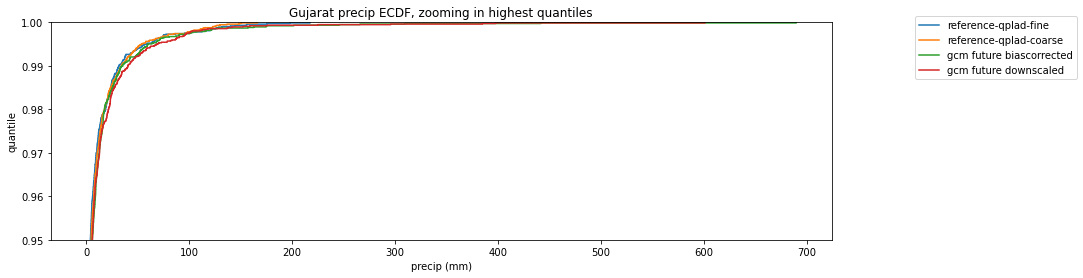

In [58]:
%%capture --no-display
series_cities_two_decades(city='Gujarat', start='2080', end='2100', datadict=datadict)

#### quantiles between [0.98, 1.0]

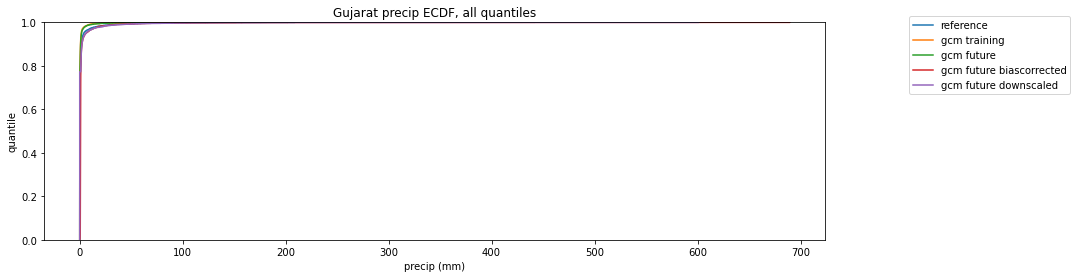

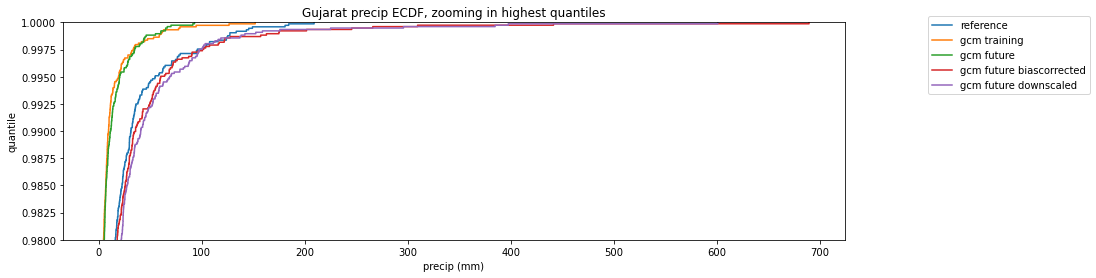

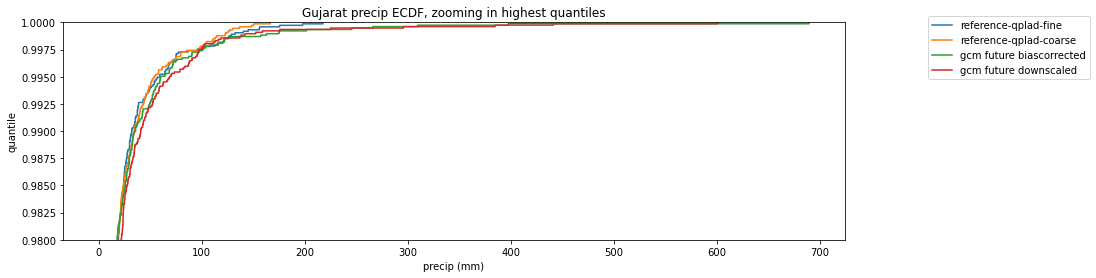

In [59]:
%%capture --no-display
series_cities_two_decades(city='Gujarat', start='2080', end='2100', datadict=datadict, zoom_in=(0.98, 1.0))